In [1]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import DivergingNorm
import cmocean as cm

## The Equation

Consider the following heat equation:

$$
\frac{\partial T}{\partial t} = \frac{\partial}{\partial z} \bigg(\kappa \frac{\partial T}{\partial z}\bigg) - w \frac{\partial T}{\partial z}+ \bigg(\frac{Q}{\rho_0 c_p z_{\text{mix}}} - \gamma(T - T_0) \bigg) \times H(z_{\text{mix}}-z) + \text{C.A.}$$ 

where $T$ is the temperature, $\kappa$ is the *constant* (for the moment!) diffusivity, $Q$ is the prescribed surface heat flux, $\rho_0 = 1025$ kg m$^{-3}$ is the reference density, $c_p = 4000$ J/(kg C) is the specific heat capacity, $z_{\text{mix}}$ is the depth of the *mixing* layer (i.e., a minimum mixed layer), $\gamma$ is a damping term which acts to restore the surface back to $T_0$, the equilibrium temperature (like a climate feedback parameter). Finally $H$ represents a Heaviside function.

We will write a forward-time, central-space finite difference scheme for this equation.

In [2]:
### Intermediate functions

def convective_adjustment(T):
    
    # These loops simplify the hidden code in the cell below which is shit but works and is also easier to understand in my head
    
    def mixing_Rahmstorf(T):
        
        for i in range(len(T) - 1):
            
            if T[i] < T[i + 1]:
                
                j = 0
                
                # This loop mixes the instability downwards
                
                while T[i + j] < T[i + j + 1]:
                    
                    T[i : i + j + 2] = np.mean(T[i : i + j + 2])
                    
                    j += 1
                    
                break
            
        return T
    
    
    # Run the Rahmstorf mixing algorithm until the instability has been eliminated from the water column (i.e., from the mixing layer) 
    
    for k in range(int(z_mix / dz)):
        
        mixing_Rahmstorf(T)
    
    return mixing_Rahmstorf(T)




def steady_state(z):
    p = w / (2 * kappa)
    q = np.sqrt(w**2 + 4 * kappa * gamma) / (2 * kappa)
    
    A = (T_b - T_0) / ((p - q) * np.exp(-(p + q) * z_mix) - (p + q) * np.exp(-(p - q) * z_mix) \
                       - kappa / w * (p**2 - q**2) * (1 - np.exp(- w / kappa * (z_b - z_mix))) \
                       * (np.exp(-(p + q) * z_mix) - np.exp(-(p - q) * z_mix)))
    
    C = A * (p**2 - q**2) * kappa / w * (np.exp(-(p + q) * z_mix) - np.exp(-(p - q) * z_mix)) * np.exp(w / kappa * z_mix)
    
    if z > - z_mix:
        return T_0 + A * ((p - q) * np.exp((p + q) * z) - (p + q) * np.exp((p - q) * z))
    
    else:
        return T_b + C * (np.exp(w / kappa * z) - np.exp(- w / kappa * z_b))

In [3]:
# ### The forward in time, central in space scheme with restoring and flux boundary conditions


# def FTCS(dt, dz, kappa, lambd, z_mix, T_initial, Q, years):
    
#     # Data
    
#     forcing = Q / (c * rho * z_mix)
#     days = dt / 86400 # Timestep in days
#     thermocline_depth = 1000 # B ase of thermocline = 1000m
#     M = int(thermocline_depth / dz) # Number of spatial steps
#     N = int(years * 360 / days) # Number of timesteps in days (taking 1 year = 360 days)
#     z = np.linspace(0.0, 1000, M + 1)
#     t = np.linspace(0.0, years * 360, N + 1)
#     Hmix = np.heaviside(z_mix - z, 1)
    
    
#     # Temperature and flux matrices. Prescribe initial and boundary conditions
    
#     T = np.zeros((M, N + 1))
#     F = np.zeros((M + 1, N + 1))
    
#     T[:, 0] = T_initial # Initial conditions
#     T[-1, :] = T_b # Temperature at base of thermocline is maintained as constant
#     F[0, :] = 0 # No flux at surface
#     #F[-1, :] = 0 # No flux at base
    
#     ### NB: NEED A STEP THAT PRESERVES THE MINIMUM MIXING LAYER, WHILST ALSO PRESERVING HEAT
    
#     for n in range(0, N):
        
#         for m in range(1, M):
            
#             F[m, n] = kappa / dz * (T[m - 1, n] - T[m, n])
            
#         for m in range(0, M - 1):
            
#             T[m, n + 1] = T[m, n] + dt / dz * (F[m, n] - F[m + 1, n]) + dt * (forcing - lambd * (T[m, n] - T0)) * Hmix[m + 1]

#         #Convective adjustment step
    
#         convective_adjustment(T[:, n + 1])
        
#     return T, z, t

In [50]:
### The forward in time, central in space scheme with restoring and flux boundary conditions


def model(dt, dz, kappa, gamma, z_mix, years, T_initial, Q):
    
    # Data
    
    forcing = Q / (c * rho * z_mix)
    days = dt / 86400 # Timestep in days
    thermocline_depth = 1000 # B ase of thermocline = 1000m
    M = int(thermocline_depth / dz) # Number of spatial steps
    N = int(years * 360 / days) # Number of timesteps in days (taking 1 year = 360 days)
    z = np.linspace(0.0, 1000, M + 1)
    t = np.linspace(0.0, years * 360, N + 1)
    Hmix = np.heaviside(z_mix - z, 1)
    
    # Temperature and flux matrices. Prescribe initial and boundary conditions
    
    T = np.zeros((M, N + 1))
    F = np.zeros((M + 1, N + 1))
    
    T[:, 0] = T_initial # Initial conditions
    T[- 1, :] = T_b # Temperature at base of thermocline is maintained as constant
    F[0, :] = 0 # No flux at surface
    #F[-1, :] = 0 # No flux at base
    
    ### NB: NEED A STEP THAT PRESERVES THE MINIMUM MIXING LAYER, WHILST ALSO PRESERVING HEAT
    
    for n in range(0, N):
        
        for m in range(1, M):
            
            F[m, n] = kappa / dz * (T[m - 1, n] - T[m, n])
            
        for m in range(0, M - 1):
            
            T[m, n + 1] = T[m, n] + dt / dz * (F[m, n] - F[m + 1, n]) + dt * (forcing[n] - gamma * (T[m, n] - T0)) * Hmix[m + 1]

        #Convective adjustment step
    
        convective_adjustment(T[:, n + 1])
        
    return T, z, t

In [5]:
# ### Functions that run the experiment

# def cwcw(T_initial, cycles):
    
#     cool = FTCS(dt, dz, kappa, gamma, z_mix, T_initial, - Q, years)[0]
    
#     cwcw_expt = cool
    
#     for i in range(cycles):
        
#         warm = FTCS(dt, dz, kappa, gamma, z_mix, cool[:, - 1], Q, years)[0] 
#         cwcw_expt = np.concatenate((cwcw_expt, warm[:, : - 1]), axis = 1)
#         # Don't include the last timestep, as this is included in the following array
        
#         cool = FTCS(dt, dz, kappa, gamma, z_mix, warm[:, - 1], - Q, years)[0]
#         cwcw_expt = np.concatenate((cwcw_expt, cool[:, : - 1]), axis = 1)
#         # Don't include the last timestep, as this is included in the following array
#         # Somehow want to include the last timestep IF we are at the last cycle
        
#     return cwcw_expt



# def wcwc(T_initial, cycles):
    
#     warm = FTCS(dt, dz, kappa, gamma, z_mix, T_initial, Q, years)[0]
#     wcwc_expt = warm
    
#     for i in range(cycles):
        
#         cool = FTCS(dt, dz, kappa, gamma, z_mix, warm[:, - 1], - Q, years)[0]
#         wcwc_expt = np.concatenate((wcwc_expt, cool[:, : - 1]), axis = 1) # Don't include the last timestep, as this is included in the following array
        
#         warm = FTCS(dt, dz, kappa, gamma, z_mix, cool[:, - 1], Q, years)[0]
#         wcwc_expt = np.concatenate((wcwc_expt, warm[:, : - 1]), axis = 1) # Don't include the last timestep, as this is included in the following array
#         # Somehow want to include the last timestep IF we are at the last cycle
        
#     return wcwc_expt

In [6]:
### Ocean heat content

def OHC(T):
    
    return rho * c * np.cumsum(T)[-1] * dz
    #return np.mean(T)



def OHC_time(T_time):
    
    OHC_time = np.empty(T_time.shape[1])
    
    for i in range(len(OHC_time)):
        
        OHC_time[i] = OHC(T_time[: , i])
        
    return OHC_time

In [49]:
# Constants, data, parameters...

rho = 1025 # kg/m^3
c = 4000 # J/(kg C)
T_0 = 22 # Top temperature
T_b = 6 # Bottom temperature

dt = 10.0 * 86400 # units: s
dz = 10 # units: m
kappa = 1e-5 # units: m^2/s
w = 1e-7 # units: m/s
gamma = 1/(365 * 3 * 86400)

z_mix = 20.0
z_b = 1000
z = np.arange(-z_b, 0, dz) # z positive upwards used to generate steady state
vss = np.vectorize(steady_state)
T_i = vss(z)[::-1] # Initial condition is the analytically determinated steady state

z = np.arange(0, z_b + dz, dz) # Now use z positive downwards for depth

In [77]:
# 'Run' the experiment
years = 100
days = dt / 86400

# Control

Q = np.ones(int(years * 360 / days) + 1) * 0
gamma_year = 6.5
gamma = 1/(gamma_year * 365 * 86400)
T0 = T_i[0] # Temperature relaxed back to. This is the surface temperature at the beginning of the experiment
control_expt = model(dt, dz, kappa, gamma, z_mix, years, T_i, Q)[0]

# Constant perturbation

Q = np.ones(int(years * 360 / days) + 1) * 5
cool_expt = model(dt, dz, kappa, gamma, z_mix, years, T_i, - Q)[0]
warm_expt = model(dt, dz, kappa, gamma, z_mix, years, T_i, Q)[0]

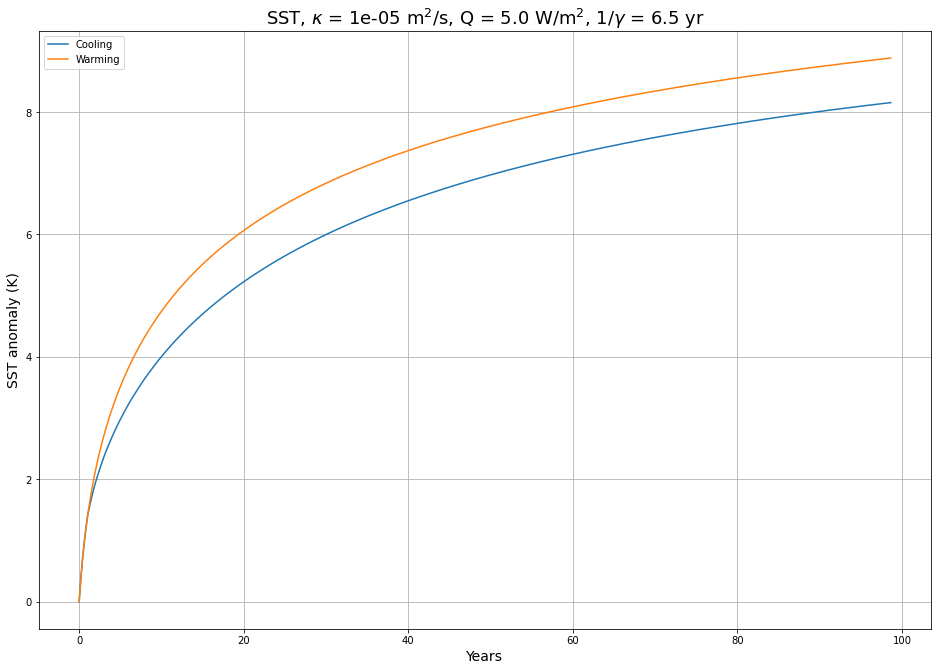

In [78]:
# Temperatures over time

plt.figure(figsize=(16,11))

days = dt / 86400
timesteps = cool_expt.shape[1]
length = (timesteps - 1) * days / 365

### SST
plt.plot(np.linspace(0, length, timesteps),  -1 * (cool_expt[0, :] - control_expt[0, :]), label='Cooling')
plt.plot(np.linspace(0, length, timesteps), warm_expt[0, :] - control_expt[0, :], label='Warming')
#plt.plot(np.linspace(0, length, timesteps), control_expt[0, :], label='Control')


plt.grid()
plt.title('SST, $\kappa$ = {} m$^2$/s, Q = {} W/m$^2$, $1/\gamma$ = {} yr'.format(kappa, Q[0], gamma_year), fontsize = 18)
plt.ylabel('SST anomaly (K)', fontsize = 14)
plt.xlabel('Years',fontsize = 14)
plt.legend()
#plt.savefig('SST and GAT anomalies, single abrupt, kappa = {}, Q = {}, gamma = {}.jpg'.format(kappa, Q, gamma_year))

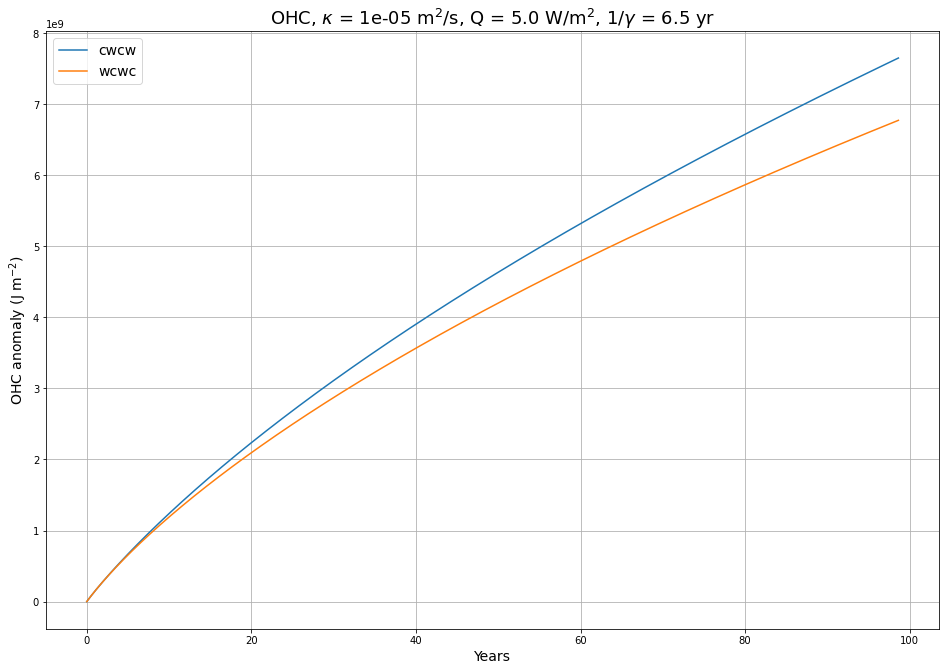

In [79]:
# Ocean heat content over time

plt.figure(figsize=(16,11))

days = dt / 86400
timesteps = cool_expt.shape[1]
length = (timesteps - 1) * days/365 

#Calculate ocean heat content
OHC_control = OHC_time(control_expt)
OHC_cool = OHC_time(cool_expt)
OHC_warm = OHC_time(warm_expt)

#Plot
plt.plot(np.linspace(0,length,timesteps), -1 * (OHC_cool - OHC_control), label='cwcw')
plt.plot(np.linspace(0,length,timesteps), OHC_warm - OHC_control, label='wcwc')
#plt.plot(np.linspace(0,length,timesteps), OHC_control, label='control')

plt.grid()
plt.title('OHC, $\kappa$ = {} m$^2$/s, Q = {} W/m$^2$, $1/\gamma$ = {} yr'.format(kappa, Q[0], gamma_year), fontsize = 18)
plt.ylabel('OHC anomaly (J m$^{-2}$)', fontsize = 14)
plt.xlabel('Years', fontsize = 14)
plt.legend(fontsize=14)
#plt.savefig('OHC, kappa = {}, Q = {}.jpg'.format(kappa, Q))

In [82]:
control_expt.shape

(100, 3601)

In [84]:
3600/2

1800.0

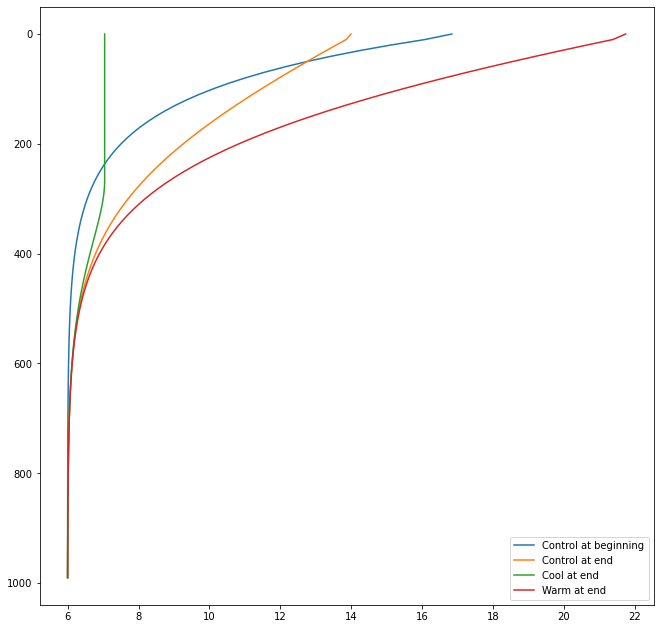

In [85]:
plt.figure(figsize=(11,11))

time_index = 1800

plt.plot(control_expt[:, 0], z[:-1], label='Control at beginning')
plt.plot(control_expt[:, time_index], z[:-1], label='Control at end')
plt.plot(cool_expt[:, time_index], z[:-1], label='Cool at end')
plt.plot(warm_expt[:, time_index], z[:-1], label='Warm at end')
plt.gca().invert_yaxis()
plt.legend()

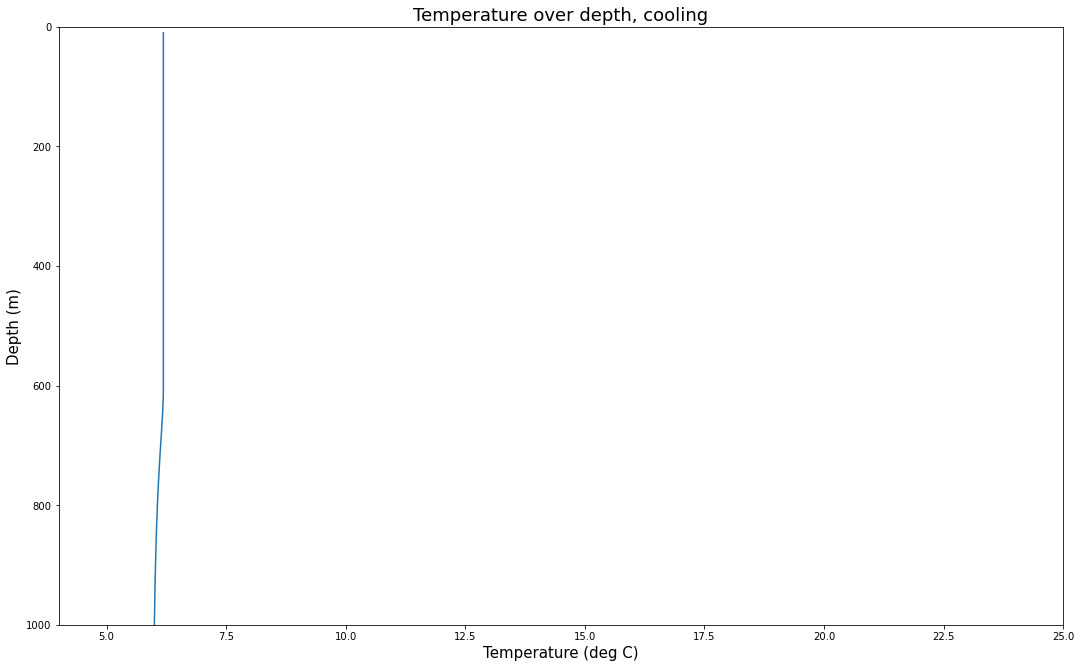

In [86]:
#Animate the forcing

fig = plt.figure(figsize=(18,11))
ax = plt.axes(xlim=(4, 25), ylim=(z[0], z[-1]))

line, = plt.plot([], [])

def init():
    line.set_data([], [])
    return line,

def animate(i):
    line.set_data(cool_expt[:, i], z[1 : ])
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(cool_expt[0, :]), interval=50, blit=True)

title = 'Temperature over depth, cooling'

ax.set_title(title, fontsize = 18)
ax.set_xlabel('Temperature (deg C)', fontsize = 15)
ax.set_ylabel('Depth (m)', fontsize = 15)
ax.invert_yaxis()

anim.save('cooling.mp4')
#plt.show()

## Oscillatory forcing

In [246]:
period_yr = 10 # units: /year
period = period_yr * 360

def step(amp, period):
    period_day = period * 365
    return amp * np.sign(np.sin((np.pi / period_day) * t))

In [247]:
# Oscilatory perturbation

A = 8
P = 10
cw_forcing = step(- A, P)
wc_forcing = step(A, P)

cw_expt = model(dt, dz, kappa, gamma, z_mix, years, T_i, cw_forcing)[0]
wc_expt = model(dt, dz, kappa, gamma, z_mix, years, T_i, wc_forcing)[0]

In [47]:
### Hovmoller plot

plt.figure(figsize=(19,13))

t_expt = np.linspace(0, 150, 5401)
tt, zz = np.meshgrid(t_expt, z)
#cwcw_expt_150years_anom = cwcw_expt_150years - T_i[..., np.newaxis]
wcwc_expt_150years_anom = wcwc_expt_150years - T_i[..., np.newaxis]

cmap = cm.cm.balance
Tmin = np.min(cwcw_expt_150years_anom)
Tmax = np.max(cwcw_expt_150years_anom)


plt.contourf(tt, zz, cwcw_expt_150years_anom, levels=51, cmap=cmap, norm=DivergingNorm(0))
plt.colorbar().set_label(label='Temperature (deg C)', size=16)

plt.title('Hovmoller plot, cwcw experiment, anomaly', fontsize = 18)
plt.xlabel('Years', fontsize = 15)
plt.ylabel('Depth (m)', fontsize = 15)
plt.gca().invert_yaxis()
#plt.savefig('Hovmoller, wcwc.jpg')

NameError: name 'cwcw_expt_150years_anom' is not defined

<Figure size 1368x936 with 0 Axes>